<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [6]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [7]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [8]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [9]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [14]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                          s["POS"].values.tolist(),
                                                          s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [15]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [17]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [20]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t, in enumerate(tags)}

In [21]:
word2idx

{'Saqiz': 1,
 'demarcation': 2,
 'keys': 3,
 'unfolding': 4,
 'Arafa': 5,
 'substances': 6,
 'Winds': 7,
 'cost-reduction': 8,
 '45.75': 9,
 'swear-in': 10,
 'Scuffles': 11,
 'Seattle-based': 12,
 'Kingibe': 13,
 'Boer': 14,
 'hypothermia': 15,
 'scorching': 16,
 'overloaded': 17,
 'vomit': 18,
 '4,50,000': 19,
 'ealier': 20,
 'prize': 21,
 'Dakota': 22,
 'opposition-led': 23,
 'extremely': 24,
 'attributable': 25,
 'feigning': 26,
 'worst-ever': 27,
 'hunted': 28,
 '4,532': 29,
 'erupted': 30,
 'Andresen': 31,
 'candle': 32,
 'temples': 33,
 'sensationalizing': 34,
 'Seif': 35,
 'research': 36,
 'delicate': 37,
 'unjustifiable': 38,
 'expansive': 39,
 'compromised': 40,
 'Berman': 41,
 'deputies': 42,
 'remnants': 43,
 'go-ahead': 44,
 'installations': 45,
 'Mwangura': 46,
 'explicitly': 47,
 'mired': 48,
 'Vase': 49,
 'Raouf': 50,
 'Disarmament': 51,
 'Tamil': 52,
 'reassuring': 53,
 'Census': 54,
 'politic': 55,
 'protective': 56,
 'sinking': 57,
 'Tohid': 58,
 'Maurice': 59,
 'cont

### Task 5: Padding Input Sentences and Creating Train/Test Splits

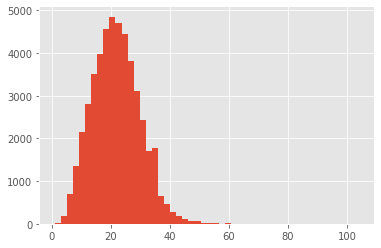

In [22]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]


In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [32]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [35]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length= max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer = 'adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

### Task 7: Train the Model

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [43]:
early_stopping = EarlyStopping(monitor='Val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

Train on 34530 samples, validate on 8633 samples
Epoch 1/3
34530/34530 [==============================] - 189s 5ms/sample - loss: 0.0546 - accuracy: 0.9840 - val_loss: 0.0521 - val_accuracy: 0.9843
Epoch 2/3
34530/34530 [==============================] - 183s 5ms/sample - loss: 0.0391 - accuracy: 0.9880 - val_loss: 0.0468 - val_accuracy: 0.9857
Epoch 3/3
34530/34530 [==============================] - 187s 5ms/sample - loss: 0.0321 - accuracy: 0.9899 - val_loss: 0.0463 - val_accuracy: 0.9860


In [ ]:
!nvidia-smi

### Task 8: Evaluate Named Entity Recognition Model

In [44]:
model.evaluate(x_test, np.array(y_test))

4796/4796 [==============================] - 5s 1ms/sample - loss: 0.0478 - accuracy: 0.9855


[0.04783616992361452, 0.9855338]

In [45]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}]\t {}\n".format("word", "True", "Pred"))
print("-"*30)

for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

word           True ]	 Pred

------------------------------
The            O	O
Sudanese       B-gpe	B-gpe
government     O	O
has            O	O
welcomed       O	O
the            O	O
Chinese        B-gpe	B-gpe
mission        O	O
to             O	O
Darfur         O	B-geo
.              O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3           O	O
93.3    